<div align="right">
  Christopher Lüken-Winkels, Lukas Blecher
</div>
# Exercise 1b
## 2 Asymptotic error of the nearest neighbor classifier for the toy example from exercise 1

$$\begin{align}
p_∞(error|X) = 1 -\sum_{k=1} p^∗ (Y = k | X)^2 &&&& \text{(1)}\\
p^*(Y=1|X)=X&&&& \text{(2)}\\
p^*(Y=0|X)=1-X&&&& \text{(3)}\\
p(X)=1&&&& \text{(4)}
\end{align}$$
Now solve the following integral: $$p_\infty(\text{error})=\int p_\infty(\text{error}|X)p(X)dX \stackrel{\text{(1)}}{=}\int \left( \sum_{k=1} p^*(Y=k|X)^2 \right)p(X)dX \stackrel{\text{(2),(3),(4)}}{=}\int \left( 1-X^2-X^2+2X-1\right)dX= \int_0^1 \left(2X-2X^2\right)dX=\left(X^2-\frac23X^3\right) \biggr\rvert^1_0=1-\frac23=\frac13$$
In exersize 1 we already approximated an error of about 33% for training sets of size 100, which confirms the theoretical solution.

## 3 Nearest Neighbor Classification on Real Data
### 3.1 Exploring the Data

In [ ]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import numpy as np
import itertools
digits = load_digits ()
print ( digits.keys () )
data = digits ["data"]
images = digits ["images"]
target = digits ["target"]
target_names = digits ["target_names"]
print ( data.dtype )
#get an image of a random "3":
threes=images[target==3] #could also use data[index].reshape((8,8)) 
img=threes[np.random.randint(len(threes))]

In [ ]:
assert 2 == len( img.shape )
plt.figure ()
plt.gray ()
plt.imshow (img , interpolation ="bicubic") # also try interpolation =" bicubic "
plt.title('3')
plt.show ()

In [ ]:
from sklearn import model_selection
X_all = data[7:] #needs to be divisible by 10 for later to work
y_all = target[7:]
X_train , X_test , y_train , y_test =\
model_selection.train_test_split ( digits.data , digits.target ,test_size = 0.4 , random_state = 0)

### 3.2 Distance function computation using loops
$$\text{dist:}\ {\rm I\!R}^{N \times D} \times {\rm I\!R}^{M \times D} \rightarrow {\rm I\!R}^{N \times M}$$ with $$N \text{: Length of training set}\\M \text{: Lenght of test set}\\D \text{: Number of pixels} = 64$$

In [ ]:
def dist_loop(training, test):
    d=[] #save distances in this matrix
    #now: fill matrix line by line
    for i in range(len(training)):
        line=[] 
        #fill line for line with the distances
        for j in range(len(test)):
            line.append(np.sqrt(np.sum(np.square(test[j]-training[i]))))
        d.append(line)
    return np.array(d)

### 3.3 Distance function computation using vectorization

In [ ]:
def dist_vec(training, test):
    #adding a new dimension to sum over (pixels) and calculate the difference to the test set in each instance
    return np.sqrt(np.sum(np.square(training[:,None]-test),axis=2))

In [ ]:
%timeit dist_loop(X_test,X_train)

In [ ]:
%timeit dist_vec(X_test,X_train)

In [ ]:
#check if both function even do the same
np.array_equal(dist_vec(X_test,X_train),dist_loop(X_test,X_train))

As we can see the vectorized solution is way faster than the looped version and gives the same result.

### 3.4 Implement the k-nearest neighbor classifier

In [ ]:
#define the subset of X_train
subX_train=X_train[(y_train==3) | (y_train==9)] #only 3's and 9's are in the subsets
subX_test=X_test[(y_test==3) | (y_test==9)]
subY_train=y_train[(y_train==3) | (y_train==9)]
subY_test=y_test[(y_test==3) | (y_test==9)]

In [ ]:
#nearest neighbor classifier
def NN(k,training,test,trainingLabel,testLabel):
    #calculate the distance matrix
    distance=dist_vec(training,test)
    guess=[]
    for i in range(len(test)):
        #get indices of smallest k distances of each column
        sorting=np.argsort(distance,axis=0).T[i][:k]
        #take the mean of all neighbors and see what integer is the most likley
        guess.append(round(np.mean(trainingLabel[sorting])))
    error=1-np.count_nonzero(np.equal(guess,testLabel))/len(testLabel)
    return error,np.array(guess)

try for $k \in [ 1, 3, 5, 9, 17,33]$

In [ ]:
err=[]
for k in [1,3,5,9,17,33]:
    errK,result=NN(k,subX_train,subX_test,subY_train,subY_test)
    err.append(errK)
print(np.mean(err),np.std(err))

So in average we get an error rate for $(1.0\pm 0.5)$%

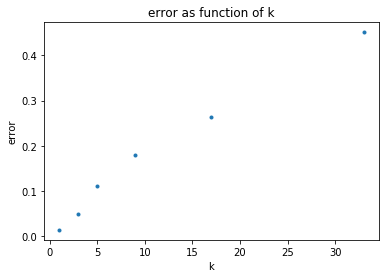

In [53]:
plt.plot([1,3,5,9,17,33],err,'.',label='error rate')
plt.xlabel('k')
plt.ylabel('error')
plt.title('error as function of k')
plt.show()

We can see that the error is growing with $k$.


### 4 Cross-validation

In [ ]:
from numpy import random as rnd

def split_folds(data, target, L):   
    #shuffle target and data in unison
    permutation = rnd.permutation(len(data))
    data,target = data[permutation],target[permutation]
    return np.array(np.array_split(data,L)),np.array(np.array_split(target,L))

In [ ]:
def cross_val(data,target,L,k):   #only works if len(data)%L == 0
    if len(data)%L!=0:
        raise ValueError('Only works with denominators of the data length')
    #start list for error values
    Err = []
    #split data
    X_folds,Y_folds = split_folds(data,target,L)
    #use each fold as test data once and the remaining folds as training set
    for i in range(L):
        X_test,Y_test = X_folds[i],Y_folds[i]
        X_train,Y_train = np.delete(X_folds,i,axis=0),np.delete(Y_folds,i,axis=0).flatten() #training set without test set
        X_train=np.array(list(itertools.chain(*X_train))) #combine packs to one big pack
        err,guess = NN(k, X_train, X_test, Y_train, Y_test)
        Err.append(err)
    return np.mean(Err),np.std(Err)

In [55]:
subX_all = X_all[(y_all==3) | (y_all==9)][2:] #only 3's and 9's are in the subsets
suby_all = y_all[(y_all==3) | (y_all==9)][2:] #remove 2 so that len(subX_all)%10=0
cross_val(subX_all,suby_all,10,8)

(0.086111111111111124, 0.036111111111111094)

So in average we get an error rate for $(0.8\pm 1.3)$%

Now we implement the pre-defined solution

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
def skNN(k,training,trainingLabel,test,testLabel):
    classifier= KNeighborsClassifier(n_neighbors=k)
    classifier.fit(training,trainingLabel) #train with the same data as in 3.4
    skGuess=classifier.predict(test)
    Error=1-np.count_nonzero(np.equal(skGuess,testLabel))/len(testLabel)
    return Error

In [ ]:
def skcross_val(data,target,L,k):   #only works if len(data)%L == 0
    if len(data)%L!=0:
        raise ValueError('Only works with denominators of the data length')
    #start list for error values
    Err = []
    #split data
    X_folds,Y_folds = split_folds(data,target,L)
    #use each fold as test data once and the remaining folds as training set
    for i in range(L):
        X_test,Y_test = X_folds[i],Y_folds[i]
        X_train,Y_train = np.delete(X_folds,i,axis=0),np.delete(Y_folds,i,axis=0).flatten() #training set without test set
        X_train=np.array(list(itertools.chain(*X_train))) #combine packs to one big pack
        err = skNN(k,X_train, Y_train, X_test, Y_test)
        Err.append(err)
    return np.mean(Err),np.std(Err)

In [ ]:
skcross_val(subX_all,suby_all,10,5)

As we can see the sklearn algorithm handles the problem better than our implementation

In [ ]:
#calculate the error and std for L=2,5,10 and for k=1,5 for both algorithms 
for algorithm in [cross_val,skcross_val]:
    for k in [1,5]:
        error,delErr=[],[]
        for L in [2,5,10]:
            e,d=algorithm(X_all,y_all,L,k)
            error.append(e)
            delErr.append(d)
        plt.errorbar([2,5,10],err,yerr=delErr,capsize=2,label='%s for $k=%i'%(['ours','sklearn'],k))
plt.title("Comparison of the algorithm's performance")
plt.xlabel('L')
plt.ylabel('error')
plt.legend()
plt.show()